In [3]:
import imageio
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
to_pil_image = transforms.ToPILImage()
def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('./outputs/generated_images.gif', imgs)
def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"./outputs/output{epoch}.jpg")
def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./outputs/loss.jpg')
    plt.show()

In [4]:
from tqdm import tqdm
import torch 
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

In [6]:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = running_loss / counter
    return val_loss, recon_images

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
kernel_size = 4 # (4, 4) kernel
init_channels = 8 # initial number of filters
image_channels = 1 # MNIST images are grayscale
latent_dim = 16 # latent dimension for sampling

In [8]:
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=0
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
# import model
import torchvision.transforms as transforms
import torchvision
import matplotlib
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
# from engine import train, validate
# from utils import save_reconstructed_images, image_to_vid, save_loss_plot
matplotlib.style.use('ggplot')

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# initialize the model
model = ConvVAE().to(device)
# set the learning parameters
lr = 0.001
epochs = 200
batch_size = 128
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [17]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
# training set and train data loader
trainset = torchvision.datasets.FashionMNIST(
    root='./input/FashionMNIST', train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)
# validation set and validation data loader
testset = torchvision.datasets.FashionMNIST(
    root='./input/FashionMNIST', train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=False
)

In [18]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, trainloader, trainset, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, testset, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)
    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

Epoch 1 of 200


469it [00:31, 15.12it/s]                         
79it [00:02, 30.86it/s]                        


Train Loss: 52132.8404
Val Loss: 44601.3906
Epoch 2 of 200


469it [00:31, 14.67it/s]                         
79it [00:02, 30.89it/s]                        


Train Loss: 44269.5932
Val Loss: 43641.9835
Epoch 3 of 200


469it [00:30, 15.18it/s]                         
79it [00:02, 31.51it/s]                        


Train Loss: 43655.8568
Val Loss: 43296.0981
Epoch 4 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.62it/s]                        


Train Loss: 43146.9444
Val Loss: 42667.9288
Epoch 5 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.47it/s]                        


Train Loss: 42739.8110
Val Loss: 42429.4846
Epoch 6 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.60it/s]                        


Train Loss: 42562.4868
Val Loss: 42322.6958
Epoch 7 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.54it/s]                        


Train Loss: 42426.3092
Val Loss: 42221.4672
Epoch 8 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.29it/s]                        


Train Loss: 42353.8914
Val Loss: 42196.3043
Epoch 9 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.57it/s]                        


Train Loss: 42278.3320
Val Loss: 42110.5602
Epoch 10 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.46it/s]                        


Train Loss: 42227.6255
Val Loss: 42051.3479
Epoch 11 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.55it/s]                        


Train Loss: 42190.7944
Val Loss: 42211.6916
Epoch 12 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.45it/s]                        


Train Loss: 42145.2731
Val Loss: 42004.0076
Epoch 13 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.56it/s]                        


Train Loss: 42113.8626
Val Loss: 41927.8809
Epoch 14 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.48it/s]                        


Train Loss: 42085.8575
Val Loss: 41926.9118
Epoch 15 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.54it/s]                        


Train Loss: 42054.6681
Val Loss: 41869.8337
Epoch 16 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.47it/s]                        


Train Loss: 42026.2369
Val Loss: 41875.8708
Epoch 17 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41996.7713
Val Loss: 41842.4928
Epoch 18 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.56it/s]                        


Train Loss: 41984.3510
Val Loss: 41853.0192
Epoch 19 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41950.5208
Val Loss: 41785.8618
Epoch 20 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.29it/s]                        


Train Loss: 41890.8051
Val Loss: 41744.4444
Epoch 21 of 200


469it [00:30, 15.29it/s]                         
79it [00:02, 31.39it/s]                        


Train Loss: 41808.7364
Val Loss: 41641.9338
Epoch 22 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.52it/s]                        


Train Loss: 41759.5009
Val Loss: 41655.7842
Epoch 23 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.38it/s]                        


Train Loss: 41693.0734
Val Loss: 41552.2314
Epoch 24 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41631.3419
Val Loss: 41462.6944
Epoch 25 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.51it/s]                        


Train Loss: 41599.9961
Val Loss: 41480.1501
Epoch 26 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41573.3621
Val Loss: 41437.2212
Epoch 27 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.39it/s]                        


Train Loss: 41550.5710
Val Loss: 41433.0981
Epoch 28 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.51it/s]                        


Train Loss: 41533.3389
Val Loss: 41437.6147
Epoch 29 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.57it/s]                        


Train Loss: 41522.7680
Val Loss: 41402.4988
Epoch 30 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.43it/s]                        


Train Loss: 41505.4365
Val Loss: 41493.0165
Epoch 31 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.51it/s]                        


Train Loss: 41493.3713
Val Loss: 41350.8923
Epoch 32 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.47it/s]                        


Train Loss: 41480.2884
Val Loss: 41369.0297
Epoch 33 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.60it/s]                        


Train Loss: 41464.9885
Val Loss: 41393.5880
Epoch 34 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.45it/s]                        


Train Loss: 41458.4940
Val Loss: 41387.1599
Epoch 35 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.58it/s]                        


Train Loss: 41449.0423
Val Loss: 41341.8613
Epoch 36 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41442.0284
Val Loss: 41309.4643
Epoch 37 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41421.0556
Val Loss: 41299.1689
Epoch 38 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.40it/s]                        


Train Loss: 41420.3308
Val Loss: 41278.4596
Epoch 39 of 200


469it [00:30, 15.29it/s]                         
79it [00:02, 31.44it/s]                        


Train Loss: 41406.3463
Val Loss: 41281.0936
Epoch 40 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41397.8352
Val Loss: 41352.4655
Epoch 41 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.46it/s]                        


Train Loss: 41399.9110
Val Loss: 41374.2545
Epoch 42 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.48it/s]                        


Train Loss: 41386.0008
Val Loss: 41254.0878
Epoch 43 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.51it/s]                        


Train Loss: 41371.2380
Val Loss: 41293.8851
Epoch 44 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41372.8983
Val Loss: 41272.4508
Epoch 45 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.46it/s]                        


Train Loss: 41370.1841
Val Loss: 41273.6205
Epoch 46 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.60it/s]                        


Train Loss: 41367.5124
Val Loss: 41312.0362
Epoch 47 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.40it/s]                        


Train Loss: 41344.7793
Val Loss: 41255.4090
Epoch 48 of 200


469it [00:31, 15.08it/s]                         
79it [00:02, 31.53it/s]                        


Train Loss: 41343.1803
Val Loss: 41239.2213
Epoch 49 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.43it/s]                        


Train Loss: 41343.4479
Val Loss: 41256.2808
Epoch 50 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.54it/s]                        


Train Loss: 41339.4200
Val Loss: 41225.5800
Epoch 51 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41335.2071
Val Loss: 41253.1394
Epoch 52 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.44it/s]                        


Train Loss: 41328.7600
Val Loss: 41301.9811
Epoch 53 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.57it/s]                        


Train Loss: 41323.0957
Val Loss: 41228.5348
Epoch 54 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.46it/s]                        


Train Loss: 41317.9015
Val Loss: 41202.3690
Epoch 55 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41316.2580
Val Loss: 41224.0714
Epoch 56 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.45it/s]                        


Train Loss: 41307.0465
Val Loss: 41212.1625
Epoch 57 of 200


469it [00:30, 15.29it/s]                         
79it [00:02, 31.42it/s]                        


Train Loss: 41303.3164
Val Loss: 41189.6745
Epoch 58 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.45it/s]                        


Train Loss: 41300.5831
Val Loss: 41234.2050
Epoch 59 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.41it/s]                        


Train Loss: 41292.1390
Val Loss: 41211.7631
Epoch 60 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.33it/s]                        


Train Loss: 41287.6163
Val Loss: 41224.9735
Epoch 61 of 200


469it [00:30, 15.28it/s]                         
79it [00:02, 31.29it/s]                        


Train Loss: 41287.0894
Val Loss: 41181.9250
Epoch 62 of 200


469it [00:31, 14.69it/s]                         
79it [00:02, 31.36it/s]                        


Train Loss: 41284.0799
Val Loss: 41240.1902
Epoch 63 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.40it/s]                        


Train Loss: 41280.5397
Val Loss: 41168.5519
Epoch 64 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.43it/s]                        


Train Loss: 41276.4936
Val Loss: 41221.5486
Epoch 65 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.38it/s]                        


Train Loss: 41274.2164
Val Loss: 41183.5917
Epoch 66 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.55it/s]                        


Train Loss: 41276.3442
Val Loss: 41179.0267
Epoch 67 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.48it/s]                        


Train Loss: 41264.9247
Val Loss: 41189.0407
Epoch 68 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.54it/s]                        


Train Loss: 41263.5147
Val Loss: 41156.8167
Epoch 69 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41262.2210
Val Loss: 41167.0592
Epoch 70 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.52it/s]                        


Train Loss: 41258.2911
Val Loss: 41172.9167
Epoch 71 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.45it/s]                        


Train Loss: 41253.6047
Val Loss: 41144.3354
Epoch 72 of 200


469it [00:30, 15.27it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41247.4729
Val Loss: 41128.6094
Epoch 73 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41245.7837
Val Loss: 41165.5504
Epoch 74 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.44it/s]                        


Train Loss: 41241.6706
Val Loss: 41162.1885
Epoch 75 of 200


469it [00:30, 15.29it/s]                         
79it [00:02, 31.40it/s]                        


Train Loss: 41238.8347
Val Loss: 41136.1062
Epoch 76 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41240.7079
Val Loss: 41245.5122
Epoch 77 of 200


469it [00:30, 15.20it/s]                         
79it [00:02, 31.55it/s]                        


Train Loss: 41237.0557
Val Loss: 41144.6771
Epoch 78 of 200


469it [00:30, 15.29it/s]                         
79it [00:02, 31.44it/s]                        


Train Loss: 41229.6861
Val Loss: 41169.9200
Epoch 79 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.52it/s]                        


Train Loss: 41227.3877
Val Loss: 41122.8049
Epoch 80 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.46it/s]                        


Train Loss: 41229.9132
Val Loss: 41150.9764
Epoch 81 of 200


469it [00:30, 15.28it/s]                         
79it [00:02, 31.38it/s]                        


Train Loss: 41222.5344
Val Loss: 41133.2098
Epoch 82 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.41it/s]                        


Train Loss: 41222.2905
Val Loss: 41138.8248
Epoch 83 of 200


469it [00:30, 15.27it/s]                         
79it [00:02, 31.52it/s]                        


Train Loss: 41221.5800
Val Loss: 41126.4189
Epoch 84 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41216.2189
Val Loss: 41122.2550
Epoch 85 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.43it/s]                        


Train Loss: 41217.9260
Val Loss: 41114.9521
Epoch 86 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.56it/s]                        


Train Loss: 41213.0358
Val Loss: 41138.9724
Epoch 87 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41212.6068
Val Loss: 41148.8843
Epoch 88 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.51it/s]                        


Train Loss: 41215.1389
Val Loss: 41128.1896
Epoch 89 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.52it/s]                        


Train Loss: 41204.5609
Val Loss: 41119.8115
Epoch 90 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.54it/s]                        


Train Loss: 41210.3258
Val Loss: 41119.3364
Epoch 91 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.67it/s]                        


Train Loss: 41201.8350
Val Loss: 41139.4243
Epoch 92 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.62it/s]                        


Train Loss: 41197.3981
Val Loss: 41154.7877
Epoch 93 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.48it/s]                        


Train Loss: 41199.4335
Val Loss: 41127.0666
Epoch 94 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.47it/s]                        


Train Loss: 41200.0435
Val Loss: 41109.8174
Epoch 95 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.48it/s]                        


Train Loss: 41197.1554
Val Loss: 41138.6508
Epoch 96 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.38it/s]                        


Train Loss: 41190.2725
Val Loss: 41114.6847
Epoch 97 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.49it/s]                        


Train Loss: 41193.6053
Val Loss: 41098.6055
Epoch 98 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.43it/s]                        


Train Loss: 41190.3758
Val Loss: 41129.9846
Epoch 99 of 200


469it [00:30, 15.27it/s]                         
79it [00:02, 30.98it/s]                        


Train Loss: 41190.5926
Val Loss: 41114.3333
Epoch 100 of 200


469it [00:30, 15.29it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41189.2417
Val Loss: 41093.5753
Epoch 101 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.76it/s]                        


Train Loss: 41180.2718
Val Loss: 41099.7907
Epoch 102 of 200


469it [00:30, 15.28it/s]                         
79it [00:02, 31.48it/s]                        


Train Loss: 41180.9359
Val Loss: 41123.4630
Epoch 103 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.06it/s]                        


Train Loss: 41184.3071
Val Loss: 41130.7773
Epoch 104 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.39it/s]                        


Train Loss: 41177.7451
Val Loss: 41089.3187
Epoch 105 of 200


469it [00:30, 15.24it/s]                         
79it [00:02, 31.48it/s]                        


Train Loss: 41172.2110
Val Loss: 41108.0731
Epoch 106 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.59it/s]                        


Train Loss: 41176.8486
Val Loss: 41128.6866
Epoch 107 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.50it/s]                        


Train Loss: 41168.3362
Val Loss: 41116.4612
Epoch 108 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.52it/s]                        


Train Loss: 41167.3739
Val Loss: 41101.4318
Epoch 109 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.53it/s]                        


Train Loss: 41170.3421
Val Loss: 41090.6046
Epoch 110 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.61it/s]                        


Train Loss: 41167.2025
Val Loss: 41092.7138
Epoch 111 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.53it/s]                        


Train Loss: 41165.3570
Val Loss: 41112.9286
Epoch 112 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.59it/s]                        


Train Loss: 41162.9498
Val Loss: 41104.1471
Epoch 113 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.55it/s]                        


Train Loss: 41159.3793
Val Loss: 41064.5610
Epoch 114 of 200


469it [00:30, 15.29it/s]                         
79it [00:02, 27.94it/s]                        


Train Loss: 41160.8280
Val Loss: 41083.7112
Epoch 115 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.55it/s]                        


Train Loss: 41161.0241
Val Loss: 41187.5907
Epoch 116 of 200


469it [00:30, 15.29it/s]                         
79it [00:02, 31.07it/s]                        


Train Loss: 41157.9960
Val Loss: 41073.7222
Epoch 117 of 200


469it [00:37, 12.55it/s]                         
79it [00:02, 31.79it/s]                        


Train Loss: 41157.5944
Val Loss: 41085.2985
Epoch 118 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.74it/s]                        


Train Loss: 41155.9152
Val Loss: 41076.2685
Epoch 119 of 200


469it [00:30, 15.37it/s]                         
79it [00:02, 31.79it/s]                        


Train Loss: 41156.8070
Val Loss: 41081.1040
Epoch 120 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.68it/s]                        


Train Loss: 41152.3060
Val Loss: 41058.5037
Epoch 121 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.75it/s]                        


Train Loss: 41153.8082
Val Loss: 41157.9428
Epoch 122 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.81it/s]                        


Train Loss: 41148.2330
Val Loss: 41082.6005
Epoch 123 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 41146.5019
Val Loss: 41076.0621
Epoch 124 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.78it/s]                        


Train Loss: 41142.8009
Val Loss: 41077.7302
Epoch 125 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 41148.2529
Val Loss: 41072.0284
Epoch 126 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.74it/s]                        


Train Loss: 41145.6685
Val Loss: 41074.8835
Epoch 127 of 200


469it [00:30, 15.37it/s]                         
79it [00:02, 31.63it/s]                        


Train Loss: 41145.5098
Val Loss: 41094.8044
Epoch 128 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.73it/s]                        


Train Loss: 41137.0964
Val Loss: 41106.2737
Epoch 129 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.76it/s]                        


Train Loss: 41141.6452
Val Loss: 41099.1047
Epoch 130 of 200


469it [00:30, 15.37it/s]                         
79it [00:02, 31.82it/s]                        


Train Loss: 41141.0965
Val Loss: 41079.4594
Epoch 131 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 41141.2992
Val Loss: 41089.1440
Epoch 132 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.76it/s]                        


Train Loss: 41136.3037
Val Loss: 41073.5789
Epoch 133 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.68it/s]                        


Train Loss: 41135.2451
Val Loss: 41085.4164
Epoch 134 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.73it/s]                        


Train Loss: 41133.4534
Val Loss: 41062.8143
Epoch 135 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.69it/s]                        


Train Loss: 41139.1336
Val Loss: 41063.4704
Epoch 136 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.74it/s]                        


Train Loss: 41131.0986
Val Loss: 41093.2930
Epoch 137 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.70it/s]                        


Train Loss: 41133.3535
Val Loss: 41066.4815
Epoch 138 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 41128.5368
Val Loss: 41046.5749
Epoch 139 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.69it/s]                        


Train Loss: 41126.5891
Val Loss: 41069.9166
Epoch 140 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.81it/s]                        


Train Loss: 41128.2677
Val Loss: 41065.5244
Epoch 141 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.72it/s]                        


Train Loss: 41123.9787
Val Loss: 41076.8646
Epoch 142 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.76it/s]                        


Train Loss: 41123.6859
Val Loss: 41074.5883
Epoch 143 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.75it/s]                        


Train Loss: 41123.4736
Val Loss: 41093.7130
Epoch 144 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.84it/s]                        


Train Loss: 41124.2203
Val Loss: 41049.2474
Epoch 145 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 41120.4111
Val Loss: 41067.5804
Epoch 146 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.82it/s]                        


Train Loss: 41123.4868
Val Loss: 41069.6460
Epoch 147 of 200


469it [00:30, 15.35it/s]                         
79it [00:02, 31.75it/s]                        


Train Loss: 41119.4151
Val Loss: 41082.0476
Epoch 148 of 200


469it [00:30, 15.33it/s]                         
79it [00:02, 31.67it/s]                        


Train Loss: 41115.4477
Val Loss: 41056.1966
Epoch 149 of 200


469it [00:30, 15.36it/s]                         
79it [00:02, 31.75it/s]                        


Train Loss: 41115.6280
Val Loss: 41075.9658
Epoch 150 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.73it/s]                        


Train Loss: 41123.4358
Val Loss: 41064.6980
Epoch 151 of 200


469it [00:30, 15.34it/s]                         
79it [00:02, 31.75it/s]                        


Train Loss: 41114.5852
Val Loss: 41058.6345
Epoch 152 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 41117.0934
Val Loss: 41064.6298
Epoch 153 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.78it/s]                        


Train Loss: 41113.7445
Val Loss: 41064.8633
Epoch 154 of 200


469it [00:30, 15.32it/s]                         
79it [00:02, 31.68it/s]                        


Train Loss: 41117.5749
Val Loss: 41052.3901
Epoch 155 of 200


469it [00:30, 15.31it/s]                         
79it [00:02, 31.76it/s]                        


Train Loss: 41108.6411
Val Loss: 41045.6538
Epoch 156 of 200


469it [00:30, 15.30it/s]                         
79it [00:02, 31.76it/s]                        


Train Loss: 41110.1405
Val Loss: 41056.7049
Epoch 157 of 200


469it [00:30, 15.28it/s]                         
79it [00:02, 31.75it/s]                        


Train Loss: 41110.5389
Val Loss: 41048.2271
Epoch 158 of 200


469it [00:30, 15.28it/s]                         
79it [00:02, 31.69it/s]                        


Train Loss: 41107.2232
Val Loss: 41076.9845
Epoch 159 of 200


469it [00:30, 15.27it/s]                         
79it [00:02, 31.66it/s]                        


Train Loss: 41108.0831
Val Loss: 41070.0821
Epoch 160 of 200


469it [00:30, 15.27it/s]                         
79it [00:02, 31.78it/s]                        


Train Loss: 41107.0220
Val Loss: 41042.8195
Epoch 161 of 200


469it [00:30, 15.24it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 41107.1806
Val Loss: 41086.9834
Epoch 162 of 200


469it [00:30, 15.24it/s]                         
79it [00:02, 31.66it/s]                        


Train Loss: 41104.5996
Val Loss: 41029.7361
Epoch 163 of 200


469it [00:30, 15.23it/s]                         
79it [00:02, 31.73it/s]                        


Train Loss: 41103.0773
Val Loss: 41059.8026
Epoch 164 of 200


469it [00:30, 15.23it/s]                         
79it [00:02, 31.71it/s]                        


Train Loss: 41103.7996
Val Loss: 41039.2551
Epoch 165 of 200


469it [00:31, 15.01it/s]                         
79it [00:02, 31.60it/s]                        


Train Loss: 41101.7026
Val Loss: 41120.9333
Epoch 166 of 200


469it [00:30, 15.22it/s]                         
79it [00:02, 31.72it/s]                        


Train Loss: 41100.7443
Val Loss: 41050.1412
Epoch 167 of 200


469it [00:30, 15.24it/s]                         
79it [00:02, 31.67it/s]                        


Train Loss: 41102.1706
Val Loss: 41044.2841
Epoch 168 of 200


469it [00:30, 15.21it/s]                         
79it [00:02, 31.72it/s]                        


Train Loss: 41099.7233
Val Loss: 41028.5242
Epoch 169 of 200


469it [00:30, 15.22it/s]                         
79it [00:02, 31.66it/s]                        


Train Loss: 41096.5960
Val Loss: 41046.1411
Epoch 170 of 200


469it [00:30, 15.21it/s]                         
79it [00:02, 31.67it/s]                        


Train Loss: 41098.0707
Val Loss: 41054.5694
Epoch 171 of 200


469it [00:30, 15.21it/s]                         
79it [00:02, 31.66it/s]                        


Train Loss: 41095.1805
Val Loss: 41047.7790
Epoch 172 of 200


469it [00:30, 15.20it/s]                         
79it [00:02, 31.68it/s]                        


Train Loss: 41100.9832
Val Loss: 41041.6765
Epoch 173 of 200


469it [00:30, 15.21it/s]                         
79it [00:02, 31.78it/s]                        


Train Loss: 41093.8518
Val Loss: 41062.4512
Epoch 174 of 200


469it [00:30, 15.20it/s]                         
79it [00:02, 31.65it/s]                        


Train Loss: 41098.7481
Val Loss: 41060.9442
Epoch 175 of 200


469it [00:30, 15.20it/s]                         
79it [00:02, 31.78it/s]                        


Train Loss: 41088.8803
Val Loss: 41067.2659
Epoch 176 of 200


469it [00:30, 15.22it/s]                         
79it [00:02, 31.70it/s]                        


Train Loss: 41093.4366
Val Loss: 41057.6152
Epoch 177 of 200


469it [00:30, 15.21it/s]                         
79it [00:02, 31.80it/s]                        


Train Loss: 41097.6280
Val Loss: 41040.3870
Epoch 178 of 200


469it [00:30, 15.20it/s]                         
79it [00:02, 31.73it/s]                        


Train Loss: 41091.9370
Val Loss: 41070.8013
Epoch 179 of 200


469it [00:31, 14.70it/s]                         
79it [00:02, 31.69it/s]                        


Train Loss: 41094.6093
Val Loss: 41051.9299
Epoch 180 of 200


469it [00:30, 15.17it/s]                         
79it [00:02, 31.73it/s]                        


Train Loss: 41089.9797
Val Loss: 41068.9553
Epoch 181 of 200


469it [00:30, 15.16it/s]                         
79it [00:02, 31.69it/s]                        


Train Loss: 41086.8231
Val Loss: 41028.3731
Epoch 182 of 200


469it [00:30, 15.17it/s]                         
79it [00:02, 31.76it/s]                        


Train Loss: 41090.8598
Val Loss: 41030.4215
Epoch 183 of 200


469it [00:30, 15.16it/s]                         
79it [00:02, 31.72it/s]                        


Train Loss: 41088.9678
Val Loss: 41045.4134
Epoch 184 of 200


469it [00:30, 15.15it/s]                         
79it [00:02, 31.77it/s]                        


Train Loss: 41085.2008
Val Loss: 41054.2897
Epoch 185 of 200


469it [00:31, 15.13it/s]                         
79it [00:02, 31.68it/s]                        


Train Loss: 41088.2065
Val Loss: 41058.6049
Epoch 186 of 200


469it [00:31, 15.12it/s]                         
79it [00:02, 31.65it/s]                        


Train Loss: 41085.9801
Val Loss: 41035.6362
Epoch 187 of 200


469it [00:31, 15.12it/s]                         
79it [00:02, 31.67it/s]                        


Train Loss: 41088.3058
Val Loss: 41046.1552
Epoch 188 of 200


469it [00:31, 15.07it/s]                         
79it [00:02, 31.28it/s]                        


Train Loss: 41086.2351
Val Loss: 41044.9614
Epoch 189 of 200


469it [00:31, 15.09it/s]                         
79it [00:02, 31.63it/s]                        


Train Loss: 41078.9268
Val Loss: 41059.8243
Epoch 190 of 200


469it [00:31, 15.06it/s]                         
79it [00:02, 31.61it/s]                        


Train Loss: 41081.7894
Val Loss: 41046.3744
Epoch 191 of 200


469it [00:31, 15.04it/s]                         
79it [00:02, 31.75it/s]                        


Train Loss: 41084.9079
Val Loss: 41020.1288
Epoch 192 of 200


469it [00:31, 15.04it/s]                         
79it [00:02, 31.69it/s]                        


Train Loss: 41082.1866
Val Loss: 41070.6241
Epoch 193 of 200


469it [00:31, 15.03it/s]                         
79it [00:02, 31.64it/s]                        


Train Loss: 41078.3717
Val Loss: 41058.8307
Epoch 194 of 200


469it [00:31, 14.91it/s]                         
79it [00:02, 31.64it/s]                        


Train Loss: 41082.5848
Val Loss: 41040.6513
Epoch 195 of 200


469it [00:31, 15.01it/s]                         
79it [00:02, 31.76it/s]                        


Train Loss: 41081.8009
Val Loss: 41032.7796
Epoch 196 of 200


469it [00:31, 15.04it/s]                         
79it [00:02, 31.64it/s]                        


Train Loss: 41077.8447
Val Loss: 41063.8220
Epoch 197 of 200


469it [00:31, 15.02it/s]                         
79it [00:02, 31.78it/s]                        


Train Loss: 41076.1806
Val Loss: 41036.4890
Epoch 198 of 200


469it [00:31, 15.03it/s]                         
79it [00:02, 31.67it/s]                        


Train Loss: 41078.7325
Val Loss: 41021.2696
Epoch 199 of 200


469it [00:31, 15.01it/s]                         
79it [00:02, 31.66it/s]                        


Train Loss: 41077.8144
Val Loss: 41021.1426
Epoch 200 of 200


469it [00:31, 15.04it/s]                         
79it [00:02, 32.00it/s]                        


Train Loss: 41070.8360
Val Loss: 41030.4440


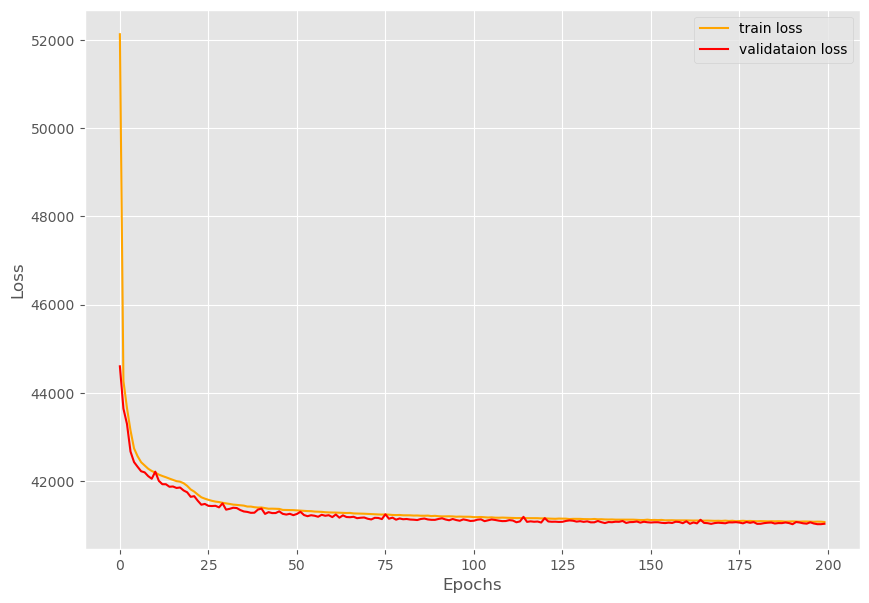

TRAINING COMPLETE


In [19]:
# save the reconstructions as a .gif file
image_to_vid(grid_images)
# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')